In [4]:
pip install earthengine-api


Note: you may need to restart the kernel to use updated packages.


In [ ]:
!earthengine authenticate --auth_mode=notebook





SyntaxError: invalid syntax (2906065299.py, line 1)

In [9]:
ee.Authenticate(auth_mode="notebook")


True

In [11]:
import ee

# Authenticate (if not already done)
ee.Authenticate()
ee.Initialize()

# Load the asset as an ImageCollection
collection = ee.ImageCollection("NASA/NEX-DCP30_ENSEMBLE_STATS")

# Get the first image from the collection
image = collection.first()

# Print metadata
print(image.getInfo())


{'type': 'Image', 'bands': [{'id': 'pr_mean', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [7025, 3105], 'crs': 'EPSG:4326', 'crs_transform': [0.00833333333, 0, -125.02083333, 0, 0.00833333333, 24.0625]}, {'id': 'pr_quartile25', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [7025, 3105], 'crs': 'EPSG:4326', 'crs_transform': [0.00833333333, 0, -125.02083333, 0, 0.00833333333, 24.0625]}, {'id': 'pr_median', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [7025, 3105], 'crs': 'EPSG:4326', 'crs_transform': [0.00833333333, 0, -125.02083333, 0, 0.00833333333, 24.0625]}, {'id': 'pr_quartile75', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [7025, 3105], 'crs': 'EPSG:4326', 'crs_transform': [0.00833333333, 0, -125.02083333, 0, 0.00833333333, 24.0625]}, {'id': 'tasmin_mean', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [7025, 3105], 'crs': 'EPSG:4326', 'crs_transform

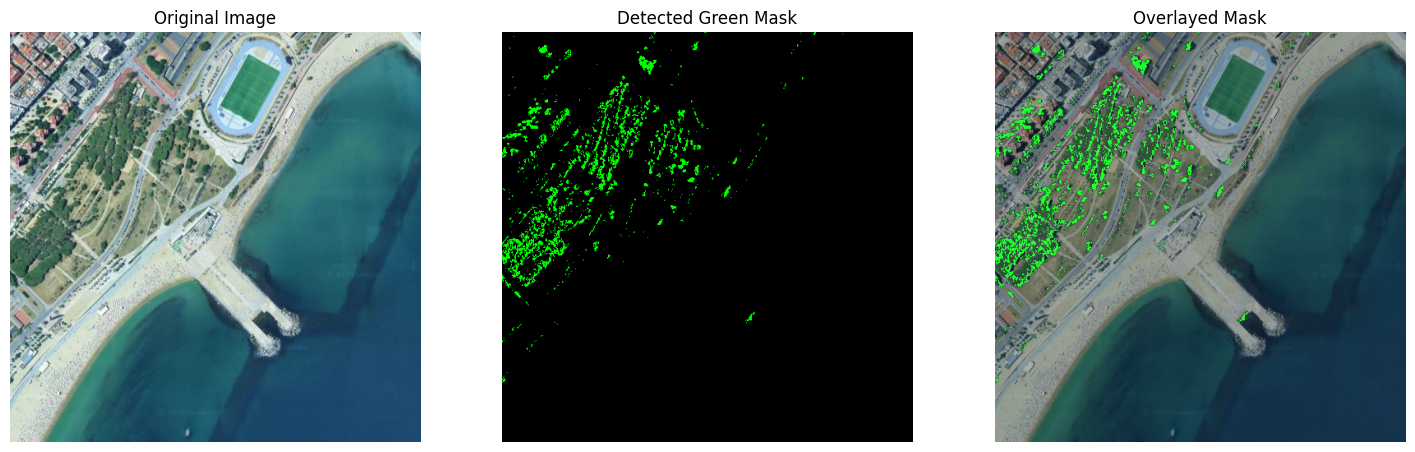

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import files

# # Upload file
# uploaded = files.upload()
image_path = r"C:\Users\LEGION\Desktop\IAAC\TERM 2\Environmental Data\DAY 01\maps\map_3.png"

# Load the image
image = cv2.imread(image_path)

# Resize the image to 500x500
image = cv2.resize(image, (500, 500))

# Convert BGR to RGB for correct display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert BGR to HSV for color detection
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define HSV range for Dark Green detection
color_ranges = {
    "Green": ([35, 50, 30], [85, 255, 100])  # Dark Green Range
}

# Create an empty mask
final_mask = np.zeros_like(image_rgb, dtype=np.uint8)

# Detect and create the mask
for color_name, (lower, upper) in color_ranges.items():
    lower = np.array(lower, dtype="uint8")
    upper = np.array(upper, dtype="uint8")

    # Create a binary mask for the selected color
    mask = cv2.inRange(image_hsv, lower, upper)

    # Convert mask to 3-channel format for visualization
    mask_colored = np.zeros_like(image_rgb)
    mask_colored[:, :, 1] = mask  # Apply green color for mask visualization

# Display the original image, detected mask, and combined overlay side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Show Original Image
axes[0].imshow(image_rgb)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Show Masked Image (Only Green Areas)
axes[1].imshow(mask_colored)
axes[1].set_title("Detected Green Mask")
axes[1].axis("off")

# Show Overlayed Image (Mask + Original)
overlaid_image = cv2.addWeighted(image_rgb, 0.7, mask_colored, 1, 0)
axes[2].imshow(overlaid_image)
axes[2].set_title("Overlayed Mask")
axes[2].axis("off")

plt.show()



Using zoom level 19 to approximate 256×256 meters


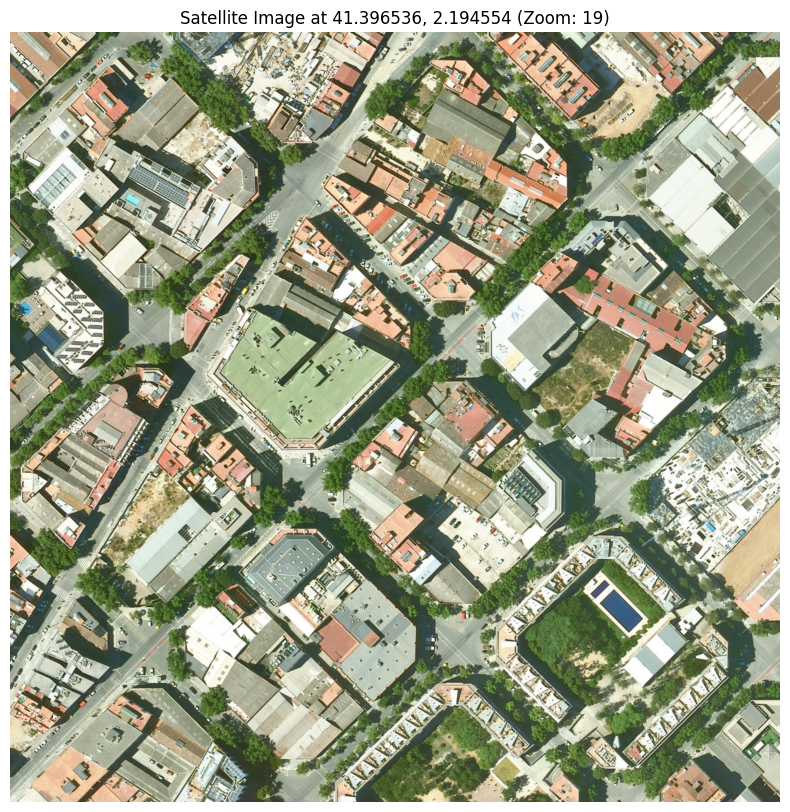

Image saved to barcelona_256m.png
Actual approximate physical dimensions: 458.7m × 458.7m
Image resolution: 2048×2048 pixels
Approximate ground resolution: 0.22 meters per pixel


In [1]:
"""
ESRI Satellite Image Download Script
------------------------------------
This script downloads high-quality satellite imagery directly from ESRI's World Imagery
service for any location on Earth. It allows you to specify the exact physical size
of the area you want to capture and the resolution of the output image.
"""

# Import required libraries
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

def calculate_zoom_for_physical_size(lat, physical_size_meters, width_pixels=800):
    """
    Calculate the appropriate zoom level needed to show a specific physical area.

    This function converts from physical dimensions (meters) to a zoom level (1-19)
    that map services use. It accounts for the fact that the physical size represented
    by a pixel varies with latitude.

    Parameters:
    -----------
    lat : float
        Latitude of the center point
    physical_size_meters : float
        Desired physical size in meters (e.g., 300 for a 300×300m area)
    width_pixels : int
        Width of the image in pixels

    Returns:
    --------
    int: Appropriate zoom level (1-19)
    """
    # Earth's circumference at the equator in meters
    earth_circumference = 40075016.686

    # At zoom level 0, the entire world fits in 256 pixels
    # Calculate how many meters each pixel represents at zoom level 0
    meters_per_pixel_at_zoom_0 = earth_circumference / 256

    # Adjust for latitude (distances get smaller as you move away from equator)
    meters_per_pixel_at_lat_zoom_0 = meters_per_pixel_at_zoom_0 * np.cos(np.radians(lat))

    # Calculate how many meters each pixel needs to represent for our desired physical size
    meters_per_pixel_needed = physical_size_meters / width_pixels

    # Calculate the zoom level where pixels will represent this physical size
    # Each zoom level doubles the detail (halves the physical size per pixel)
    zoom = np.log2(meters_per_pixel_at_lat_zoom_0 / meters_per_pixel_needed)

    # Round to nearest integer and ensure the zoom level is within valid range
    return max(1, min(19, round(zoom)))

def download_esri_satellite_image(lat, lon, width=800, height=800, zoom=15, output_file='satellite.png'):
    """
    Download a satellite image directly from ESRI World Imagery service.

    This function downloads and stitches together multiple map tiles to create
    a complete satellite image centered at the specified coordinates.

    Parameters:
    -----------
    lat : float
        Latitude of the center point
    lon : float
        Longitude of the center point
    width : int
        Image width in pixels
    height : int
        Image height in pixels
    zoom : int
        Zoom level (1-19, higher = more detail)
    output_file : str
        Path to save the output image

    Returns:
    --------
    str: Path to the output image
    """
    # These helper functions convert geographic coordinates to tile coordinates
    def lon_to_x(lon, zoom):
        """Convert longitude to tile x-coordinate"""
        return ((lon + 180) / 360) * (2 ** zoom)

    def lat_to_y(lat, zoom):
        """Convert latitude to tile y-coordinate"""
        lat_rad = math.radians(lat)
        return (1 - math.log(math.tan(lat_rad) + 1/math.cos(lat_rad)) / math.pi) / 2 * (2 ** zoom)

    # Calculate which tiles contain our desired location
    x_tile = lon_to_x(lon, zoom)
    y_tile = lat_to_y(lat, zoom)

    # Calculate the exact pixel within that tile
    # (Not directly used but useful for debugging)
    x_pixel = int((x_tile - int(x_tile)) * 256)
    y_pixel = int((y_tile - int(y_tile)) * 256)

    # Create a blank image to hold our map
    result = Image.new('RGB', (width, height))

    # Calculate the range of tiles we need to download
    # Map tiles are 256×256 pixels, so we need to download enough tiles
    # to cover our requested dimensions
    x_min = int(x_tile - (width / 256) / 2)
    y_min = int(y_tile - (height / 256) / 2)
    x_max = int(x_tile + (width / 256) / 2) + 1
    y_max = int(y_tile + (height / 256) / 2) + 1

    # Download each tile and stitch them together
    print(f"Downloading {(x_max-x_min)*(y_max-y_min)} map tiles...")
    for x in range(x_min, x_max):
        for y in range(y_min, y_max):
            # ESRI World Imagery tile URL
            url = f"https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{zoom}/{y}/{x}"

            try:
                # Download the tile
                response = requests.get(url)
                if response.status_code == 200:
                    # Convert the response to an image
                    tile = Image.open(io.BytesIO(response.content))

                    # Calculate where to paste this tile in our result image
                    paste_x = (x - x_min) * 256
                    paste_y = (y - y_min) * 256

                    # Paste the tile into the result image
                    result.paste(tile, (paste_x, paste_y))
            except Exception as e:
                print(f"Error downloading tile {x},{y}: {e}")

    # Crop the image to center on the requested coordinates
    # This step ensures we get exactly the requested dimensions
    center_x = (width // 2)
    center_y = (height // 2)
    left = center_x - (width // 2)
    upper = center_y - (height // 2)
    right = center_x + (width // 2)
    lower = center_y + (height // 2)

    result = result.crop((left, upper, right, lower))

    # Save the image
    result.save(output_file)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(result)
    plt.axis('off')
    plt.title(f"Satellite Image at {lat}, {lon} (Zoom: {zoom})")
    plt.show()

    print(f"Image saved to {output_file}")

    return output_file

def download_esri_by_size(lat, lon, physical_size_meters=256, output_file='satellite_sized.png', width=800, height=800):
    """
    Download a satellite image covering a specific physical area on the ground.

    This is the main function you'll want to use most of the time. It combines
    the zoom calculation with the download function to get an image covering
    approximately the physical area you specify.

    Parameters:
    -----------
    lat : float
        Latitude of the center point
    lon : float
        Longitude of the center point
    physical_size_meters : float
        Desired physical size in meters (e.g., 500 for a 500×500m area)
    output_file : str
        Path to save the output image
    width : int
        Image width in pixels (resolution)
    height : int
        Image height in pixels (resolution)

    Returns:
    --------
    str: Path to the output image
    """
    # First, calculate the zoom level needed for this physical size
    # We need to pass the width to the calculation function
    zoom = calculate_zoom_for_physical_size(lat, physical_size_meters, width_pixels=width)

    print(f"Using zoom level {zoom} to approximate {physical_size_meters}×{physical_size_meters} meters")

    # Download the image with that zoom level, passing along the width and height
    image_file = download_esri_satellite_image(lat, lon, width, height, zoom, output_file)

    # Calculate the actual physical dimensions we got with this zoom level
    # (Map zoom levels are discrete, so we can't get exactly the size requested)
    earth_circumference = 40075016.686
    meters_per_pixel = (earth_circumference * np.cos(np.radians(lat))) / (256 * (2 ** zoom))
    width_meters = width * meters_per_pixel
    height_meters = height * meters_per_pixel

    print(f"Actual approximate physical dimensions: {width_meters:.1f}m × {height_meters:.1f}m")
    print(f"Image resolution: {width}×{height} pixels")
    print(f"Approximate ground resolution: {meters_per_pixel:.2f} meters per pixel")

    return image_file

def get_satellite_image(lon, lat, physical_size_meters=256, resolution=800, output_file=None):
    """
    A simple wrapper function that accepts parameters in any order and with defaults.

    This function makes it easier to use the satellite image downloading capability
    with a more straightforward interface.

    Parameters:
    -----------
    lon : float
        Longitude of the center point
    lat : float
        Latitude of the center point
    physical_size_meters : float
        Desired physical size in meters (e.g., 256 for a 256×256m area)
    resolution : int
        Resolution of the output image (both width and height will be set to this)
    output_file : str, optional
        Path to save the output image. If None, a default name will be generated.

    Returns:
    --------
    str: Path to the output image
    """
    # Generate a default filename if none provided
    if output_file is None:
        output_file = f"satellite_{resolution}px.png"

    # Call the main function with all parameters
    return download_esri_by_size(
        lat=lat,
        lon=lon,
        physical_size_meters=physical_size_meters,
        output_file=output_file,
        width=resolution,
        height=resolution
    )

# Example usage with the direct function
def example_direct():
    # Download a high-resolution satellite image of Barcelona
    download_esri_by_size(
        lat=41.396536, #iaac
        lon=2.194554, #iaac
        physical_size_meters=256,
        output_file='barcelona_256m.png',
        #output_file='my_folder/barcelona_256m.png',
        width=2048,  # Higher resolution
        height=2048
    )

example_direct()



In [ ]:
%pip install earthengine-api geemap
import ee
import geemap
import datetime

# Authenticate and Initialize Earth Engine
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

def get_nearest_image(year, bbox):
    """
    Fetch the closest available satellite image for a given year and bounding box.
    Falls back to the nearest year if the exact year is not available.
    """
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    
    # Convert bounding box (xmin, ymin, xmax, ymax) to GEE geometry
    roi = ee.Geometry.BBox(*bbox)

    # Try using Sentinel-2 (2015+) as the primary dataset
    collection = (ee.ImageCollection("COPERNICUS/S2")
                  .filterBounds(roi)
                  .filterDate(start_date, end_date)
                  .sort("system:time_start"))

    # Get the first image available
    image = collection.first()
    
    if image.getInfo() is None:
        print(f"No image found for {year}, searching for closest year...")
        # Search within a wider date range if no images are found
        collection = (ee.ImageCollection("COPERNICUS/S2")
                      .filterBounds(roi)
                      .sort("system:time_start"))  # Sort by date to get the closest

        image = collection.first()

    if image.getInfo() is None:
        print("No Sentinel-2 image available, trying Landsat...")
        # Fallback to Landsat if Sentinel-2 is not available
        collection = (ee.ImageCollection("LANDSAT/LC08/C01/T1_TOA")
                      .filterBounds(roi)
                      .sort("system:time_start"))
        image = collection.first()

    if image.getInfo() is None:
        print("No GEE imagery found! You might need to use ESRI basemap.")
        return None

    print(f"Found image from {image.date().format('YYYY-MM-dd').getInfo()}")
    return image.clip(roi)

def download_image(image, bbox, filename="satellite_image.tif"):
    """Download the selected image clipped to the bounding box."""
    if image is None:
        print("No image to download.")
        return

    url = image.getDownloadURL({
        'scale': 10,  # Resolution (meters per pixel)
        'region': ee.Geometry.BBox(*bbox).getInfo(),
        'fileFormat': 'GeoTIFF'
    })

    print(f"Download URL: {url}")

# Example input
year = int(input("Enter year: "))
bbox = [-74.1, 40.7, -73.9, 40.8]  # Example: NYC bounding box (xmin, ymin, xmax, ymax)

image = get_nearest_image(year, bbox)
download_image(image)



ModuleNotFoundError: No module named 'geemap'

In [21]:
import ee

# Authenticate & Initialize GEE
ee.Authenticate()
ee.Initialize()

# 🔹 USER INPUT: Define year, month, and bounding box
year = 2022
month = 7  # July
bbox = ee.Geometry.BBox(-74.2, 40.5, -73.7, 40.9)  # New York area

# 🔹 Load Image Collection (Sentinel-2 or Landsat)
collection = ee.ImageCollection("COPERNICUS/S2") \
    .filterBounds(bbox) \
    .filterDate(f"{year}-{month:02d}-01", f"{year}-{month:02d}-28") \
    .sort("CLOUD_COVER")

# 🔹 Select the first available image (closest to input month)
image = collection.first()

# 🔹 Clip image to bounding box
image = image.clip(bbox)

# 🔹 Download Image
url = image.getDownloadURL({
    'scale': 50,  # Resolution (10m for Sentinel-2, 30m for Landsat)
    'region': bbox.getInfo(),
    'format': 'GeoTIFF'
})

print("Download URL:", url)


Download URL: https://earthengine.googleapis.com/v1/projects/564478090670/thumbnails/f67f07e8caae00e33ac1586cee3d681f-f1acd24c351920ef8f745d28defcd388:getPixels


In [22]:
# Download the TIFF file from 'url' and save it
response = requests.get(url)
with open(filename_tiff, "wb") as f:
    f.write(response.content)
    
# Open the TIFF and convert it to PNG
image_tiff = Image.open(filename_tiff)
image_tiff.save(filename_png)
print("TIFF downloaded from URL and converted to PNG.")


More samples per pixel than can be decoded: 16


UnidentifiedImageError: cannot identify image file 'satellite_image.tif'

FileNotFoundError: [Errno 2] No such file or directory: 'satellite_image.tif'